# Linear models

## Linear regression

For a set of inputs
$$({\bf x}_i, y_i),$$
$${\bf x}_i\in \mathbb{R}^M,$$
$$y_i\in \mathbb{R}^1,$$
$$i=1,\ldots,N$$
we are looking for a function of the form
$$f({\bf x}) = {\bf w}^T{\bf x} + b,$$
$${\bf w}\in \mathbb{R}^M,$$
$$b\in \mathbb{R}^1$$
such that
$$\sum_{i=1}^N(y_i - f({\bf x}_i))^2$$
is minimal.

Let's do our regular imports:

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We are going to use a linear regression model to fit a 3rd order polynomial.

In [0]:
nx = 15 # number of points
np.random.seed(42) # to reproduce the same random state
x = np.sort(np.random.uniform(-2., 2., size=nx))
y = x**3 - 1.5 * x**2 - 2. * x - 1
y += np.random.normal(scale=0.7, size=nx) # adding some noize to the data

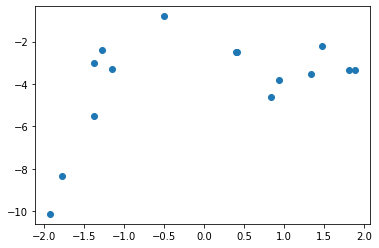

In [3]:
plt.plot(x, y, 'o', markersize=6);

We will use the scikit-learn library (https://scikit-learn.org/). Let's import its `linear_model` module:

In [0]:
from sklearn import linear_model

`sklearn` models expect that our input to be of shape `(n_samples, n_features)`. So far we have only one single feature, so we have to reshape our input to `(n_samples, 1)`. Let's write a function for that:

In [5]:
def get_features(x):
  """
  Function that takes 1-dimensional array x and returns
  2-dimensional array of the shape (n_samples, n_features)
  """
  return np.reshape(x, (len(x),1))

assert(get_features(x).shape == (nx, 1))
print(get_features(x).shape)

(15, 1)


Ok, now it's time to build and train the model:

In [6]:
model = linear_model.LinearRegression()
model.fit(get_features(x), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's write a function to plot the results:

In [0]:
def plot_model(model, features):
  """
  Function that plots the data points and
  model prediction
  """
  plt.plot(x, y, 'o', markersize=6);
  
  # Hint: use model.predict(features(<ARRAY OF X>))
  # to get an array of predictions
  y_pred = model.predict(get_features(x))
  plt.plot(x, y_pred)


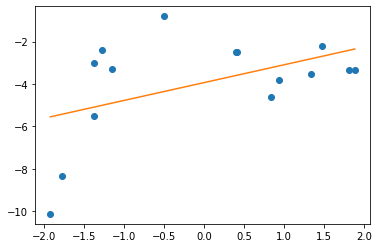

In [8]:
plot_model(model, get_features(x))

Obviously, linear model can't fit a non-linear dependency. Or can it?

Can you think of a modification to the inputs such that our model turns to a higher degree polynomial fit?

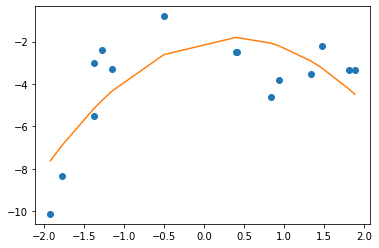

In [9]:
def get_features(x):
  """
  Function that takes 1-dimensional vector x and returns
  2-dimensional array of the shape (n_samples, n_features)
  with non-linear features
  """
  x2 = np.c_[x, x**2]
  return x2

model = linear_model.LinearRegression()
model.fit(get_features(x), y)

plot_model(model, get_features(x))

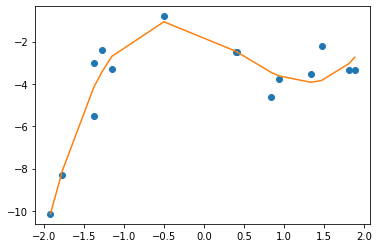

In [10]:
def get_features(x):
  """
  Function that takes 1-dimensional vector x and returns
  2-dimensional array of the shape (n_samples, n_features)
  with non-linear features (power 1, 2 and 3)
  """
  x3 = np.c_[x, x**2, x**3]
  return x3

model = linear_model.LinearRegression()
model.fit(get_features(x), y)

plot_model(model, get_features(x))

3rd order polynomial fit looks good! Can we go higher?

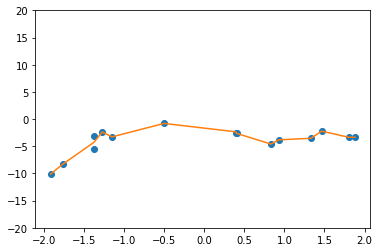

In [11]:
def get_features(x):
  """
  Function that takes 1-dimensional vector x and returns
  2-dimensional array of the shape (n_samples, n_features)
  with non-linear features of high powers (12?)
  """
  # l = [x**i for i in range(1,13)]
  new_x = np.c_[x, x**2, x**3, x**4, x**5, x**6, x**7, x**8, x**9, x**10, x**11, x**12]
  return new_x

model = linear_model.LinearRegression()
model.fit(get_features(x), y)

plot_model(model, get_features(x))
plt.ylim(-20, 20);

Hmm, is this fit better? It certainly goes closer to the input points...  Let's test its predictive power:

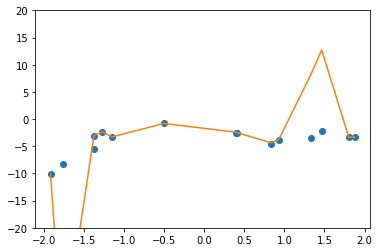

In [12]:
np.random.seed(42)
selection = np.random.binomial(1, 0.7, len(x)).astype(bool)

model = linear_model.LinearRegression()
model.fit(get_features(x[selection]), y[selection])

plot_model(model, get_features(x))
plt.ylim(-20, 20);

So it doesn't describe the points it has never seen. This is called **overfitting**.

## k-fold cross-validation

This is a common validation method:
  - split the dataset $D$ to $k$ parts: $D_i$, $i=1,\ldots,k$
  - for each $i=1,\ldots,k$ do the following:
    - fit the model on $D \setminus D_i$ (on all elements from $D$ that are not in $D_i$)
    - evaluate model performance on $D_i$: obtain score $l_i$
  - calculate the average score $l=\frac{1}{k}\sum_{i=1}^kl_i$ of the model's performance.

Let's assume we don't know the nature of our input data and we want to select the best model. We can use k-fold cross-validation method to evaluate our model for each polynomial order.

Scikit-learn has the `model_selection` module with k-fold x-validation functionality implemented.

In [0]:
from sklearn import model_selection


# defining our score function (root mean square loss - the smaller the better)
def rms_loss(y_true, y_pred):
  return np.sqrt(np.mean((y_true - y_pred)**2))

assert np.isclose(rms_loss(np.arange(10), np.linspace(-3, 80, 10)), 41.39735185661929), "Check your rms_loss function"


# train and evaluate the model on a single split
def single_eval(x_train, y_train, x_test, y_test, features):
  model = linear_model.LinearRegression()
  model.fit(features(x_train), y_train)
  return rms_loss(y_test, model.predict(features(x_test)))


# run the k-fold x-validation loop and return the array of losses
def test_model(features, n_splits=5):
  kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=1234)
  rms = []
  for i_train, i_test in kf.split(x):
    rms.append(single_eval(x[i_train], y[i_train], x[i_test], y[i_test], features))
  return np.array(rms)

In [0]:
rms_vs_power = [
    (i, test_model(
          lambda x: np.stack([x**n for n in range(1, i + 1)]).T
    )) for i in range(1, 14)
]

powers, rmss = zip(*rms_vs_power)
rmss = np.array(rmss)

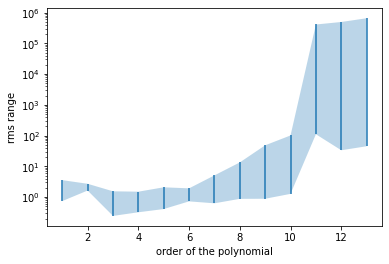

In [15]:
plt.fill_between(x=powers,
                 y1=rmss.min(axis=1),
                 y2=rmss.max(axis=1),
                 alpha=0.3
                );

plt.errorbar(x=powers,
             y   =(rmss.max (axis=1) + rmss.min (axis=1)) * 0.5,
             yerr=(rmss.max (axis=1) - rmss.min (axis=1)) * 0.5,
             fmt=' ');

plt.yscale('log')
plt.xlabel('order of the polynomial')
plt.ylabel('rms range');

## Logistic regression

Binary classification:
$$y_i\in\left\{0; 1\right\}$$

Model:
$$P(y=1|{\bf x}, {\bf W}) = \sigma({\bf W}\cdot{\bf x}),$$
where $\sigma$ is the *sigmoid* function:
$$\sigma(a) = \frac{1}{1 + e^{-a}}$$



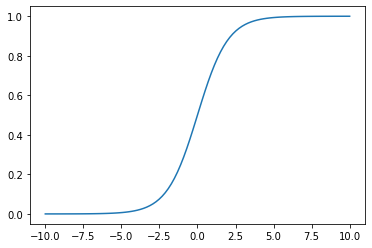

In [16]:
def sigmoid(x):
  """
  Sigma function (from the definition above)
  """
  return 1/(1+np.exp(-x))

x = np.linspace(-10, 10, 100)
plt.plot(x, sigmoid(x));

This model is implemented in scikit-learn with the following default loss (cross-entropy):
$$L({\bf W})=-\sum_i\left(
y_i\, log P(y=1|{\bf x}_i, {\bf W})
+
(1-y_i)logP(y=0|{\bf x}_i, {\bf W})
\right)$$
plus a regularization term $\frac{1}{2}{\bf W}\cdot{\bf W}$.

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Let's try to separate two rectangular clusters with it.

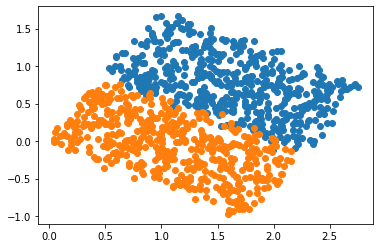

In [17]:
N0 = 512
N1 = 512

X0_ = np.random.uniform(size=(N0, 2)) * [[2, 1]] + np.random.normal(scale=0.05, size=(N0, 2)) + [[0, 1]]
X1_ = np.random.uniform(size=(N1, 2)) * [[2, 1]] + np.random.normal(scale=0.05, size=(N0, 2))


alpha = np.pi / 6.
rot = [[ np.cos(alpha), np.sin(alpha)],
       [-np.sin(alpha), np.cos(alpha)]]
X0 = np.matmul(rot, X0_.T).T
X1 = np.matmul(rot, X1_.T).T

y0 = np.zeros(shape=N0)
y1 = np.ones (shape=N1)

X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([y0, y1], axis=0)
perm = np.random.permutation(len(y))
X = X[perm]
y = y[perm]

plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

In [0]:
from sklearn import metrics

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

preds_train = model.predict_proba(X_train)[:,1]
preds_test  = model.predict_proba(X_test )[:,1]

print("train score: {}".format(metrics.roc_auc_score(y_train, preds_train)))
print("test score:  {}".format(metrics.roc_auc_score(y_test , preds_test )))

train score: 0.999049919921822
test score:  0.9981577008106116


### ROC-curve and AUC

We've just used `roc_auc_score` function to evaluate our model. What is that?

Consider the output discriminating function $p^\hat{y}$ our model produces (class 1 probability):

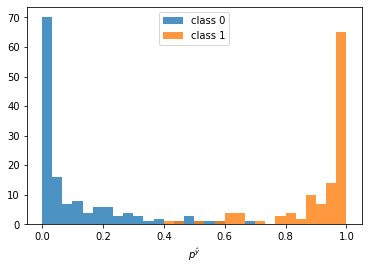

In [20]:
bins = np.linspace(-0., 1., 31)
plt.hist(preds_test[y_test == 0], bins=bins, alpha=0.8, label='class 0')
plt.hist(preds_test[y_test == 1], bins=bins, alpha=0.8, label='class 1')
plt.xlabel('$p^\hat{y}$')
plt.legend();

If we want to select only class 1 events, we can introduce a threshold $T$ and only select events with class 1 probability greater than $T$:
$$p^\hat{y} > T.$$
For some value of $T$ false positive rate is defined as:
$$\text{FPR}(T) = P(p^\hat{y} > T | y=0),$$
i.e. probability for the class 0 component to exceed the threshold. Similarly, true positive rate is defined as:
$$\text{TPR}(T) = P(p^\hat{y} > T | y=1).$$

Now, if we plot TPR versus FPR for all possible values of $T$ we'll get the **receiver operating characteristic**, or simply **ROC-curve**:

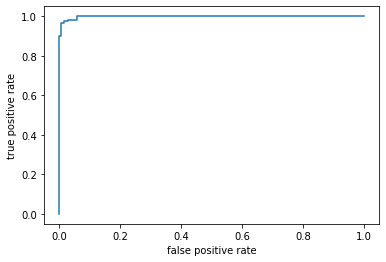

In [21]:
fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)

plt.plot(fpr, tpr);
plt.xlabel('false positive rate')
plt.ylabel('true positive rate');

This curve shows how well our model can separate the classes. To convert it to a single number we calculated the **area ander the ROC-curve** (AUC). The grater this area is, the better separation we get.

By the way, AUC also equals to the probability that the discriminating variable value for a random class 1 object is greater than such value for a random class 0 object:
$$\text{AUC} = P(p^{\hat{y}}_a > p^{\hat{y}}_b|y_a=1,y_b=0)$$

Now, let's write a function that plots a 2d map of our model's predictions:

In [0]:
from matplotlib import colors

In [0]:
k = 0.85
thr1 = 0.25
thr2 = 1. - thr1

thrs = np.array([0., thr1, 0.5, thr2, 1.0])
blue  = np.array([0.5, 0.75, 1.])
white = np.array([1., 1., 1.])
green = np.array([0.5, 1., 0.75])
cm_colors = np.stack([green * k,
                      green,
                      white,
                      blue,
                      blue * k][::-1], axis=1)

cmap = colors.LinearSegmentedColormap('custom_cmap_blue2green', {    
         'red'   :  np.stack([thrs, cm_colors[0], cm_colors[0]], axis=1),
         'green' :  np.stack([thrs, cm_colors[1], cm_colors[1]], axis=1),
         'blue'  :  np.stack([thrs, cm_colors[2], cm_colors[2]], axis=1)})

def visualize_model(
        model,
        grid0=np.linspace(-0.5, 3.0, 100),
        grid1=np.linspace(-1.5, 2.0, 100),
        feature_transform=lambda x: x
    ):
  x0, x1 = np.meshgrid(grid0, grid1)
  xx = np.stack([x0.flatten(), x1.flatten()], axis=1)
  y = model.predict_proba(feature_transform(xx))[:,1].reshape(x0.shape)
  cnt = plt.contourf(x0, x1, y, 100, cmap=cmap)

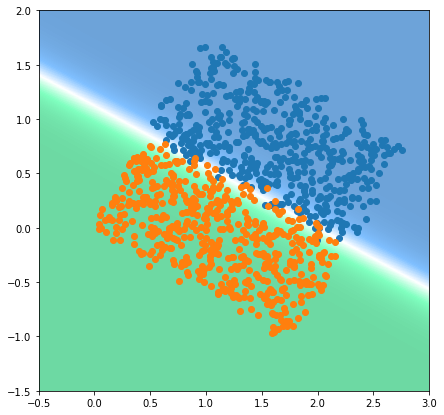

In [24]:
plt.figure(figsize=(7, 7))
visualize_model(model)
plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

Good. Now, we'll try a more complicated topology: concentric rings.

In [0]:
from sklearn import datasets

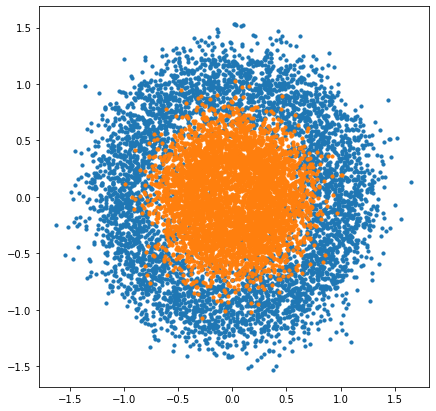

In [26]:
X, y = datasets.make_circles(n_samples=10000, shuffle=True, noise=0.2, factor=0.4)
plt.figure(figsize=(7, 7))
plt.scatter(*X[y==0].T, s=10);
plt.scatter(*X[y==1].T, s=10);

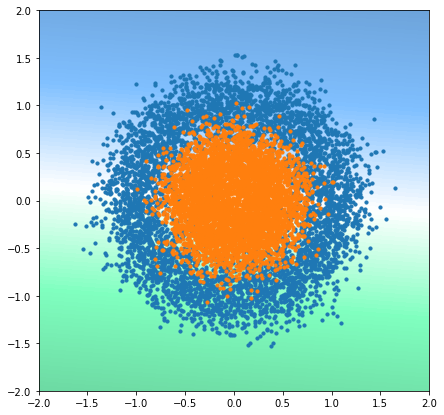

In [27]:
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.figure(figsize=(7,7))
visualize_model(model,
                np.linspace(-2., 2., 100),
                np.linspace(-2., 2., 100));
plt.scatter(*X[y==0].T, s=10);
plt.scatter(*X[y==1].T, s=10);

Again, linear model doesn't seem to be good enough to describe the data. Or does it?

In [28]:
X[:, 0]

array([-0.27600904,  0.51165675, -0.40551196, ..., -0.46651157,
       -0.33215179,  0.27918231])

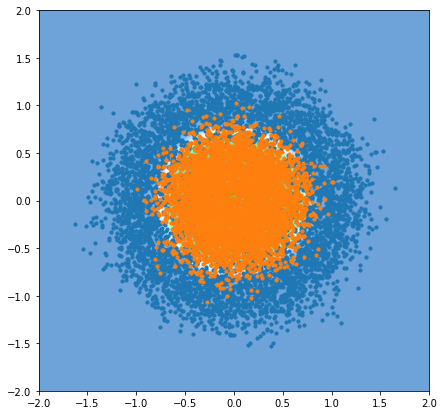

In [29]:
def features(xx):
  """
  Function that transforms features array of shape (n_sample, n_features)
  adding non-linear features
  """
  return np.c_[xx[:, 0], xx[:, 1], xx[:, 0]**2, xx[:, 1]**2]


model = linear_model.LogisticRegression()
model.fit(features(X), y)

plt.figure(figsize=(7,7))
visualize_model(model,
                np.linspace(-2., 2., 100),
                np.linspace(-2., 2., 100),
                features)
plt.scatter(*X[y==0].T, s=10);
plt.scatter(*X[y==1].T, s=10);

In [0]:
def single_eval(x_train, y_train, x_test, y_test, features, plot=False):
  model = linear_model.LogisticRegression()
  model.fit(features(x_train), y_train)
  preds_test = model.predict_proba(features(x_test))[:,1]
  if plot:
    fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)
    plt.plot(fpr, tpr)
  return metrics.roc_auc_score(y_test, preds_test)

def test_model(features, n_splits=30, plot=False):
  kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=1234)
  aucs = []
  for i_train, i_test in kf.split(X):
    aucs.append(single_eval(X[i_train], y[i_train], X[i_test], y[i_test], features, plot=plot))
  return np.array(aucs)

AUC = 0.9816 +\- 0.0009


Text(0, 0.5, 'tpr')

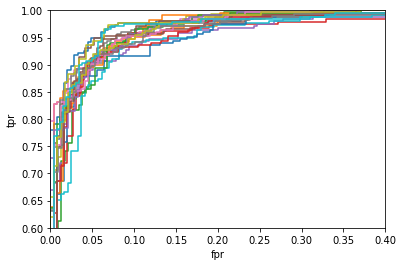

In [31]:
N = 20
aucs = test_model(features, n_splits=N, plot=True)
print("AUC = {:.4f} +\- {:.4f}".format(aucs.mean(), aucs.std() / N**0.5))
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.xlabel('fpr')
plt.ylabel('tpr')

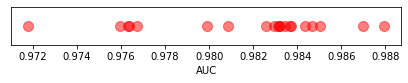

In [32]:
plt.figure(figsize=(7, 0.7))
plt.scatter(aucs, [0] * len(aucs), s=100, alpha=0.5, c='r');
plt.yticks([]);
plt.xlabel("AUC");